<a href="https://colab.research.google.com/github/shgyg99/handwrittenmathsolutions/blob/main/mathTOlatex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

torch.cuda.is_available()

True

# **🔴ENVIRONMENT SETUP**

In [2]:
!pip install -q torchmetrics
!pip install -q wandb
!pip install -q fastai
!pip install -q pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 22.7 MB/s eta 0:00:00


In [3]:
!pip uninstall torchvision torch -y
!pip install -q torch==2.5 torchvision==0.20

Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 824.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 109.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu124 requires torch==2.5.1, but you have torch 2.5.0 which is incompatible.


# **🔴IMPORT LIBS**

In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms as TT
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch import optim
from torch.nn import functional as F

from tokenizers import Tokenizer, models, trainers, pre_tokenizers
import wandb
import tqdm
import torchmetrics as tm
from PIL import Image

# **🔴UTILS**

In [5]:

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [7]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

# **🔴ARGUMENTS**

In [8]:
config = {
    "seed": 1234,

    "trainer": {
        "overfit_batches": 0.0,
        "check_val_every_n_epoch": 3,
        "fast_dev_run": False,
        "max_epochs": 200,
        "min_epochs": 1,
        "num_sanity_val_steps": 0,
    },

    "callbacks": {
        "model_checkpoint": {
            "save_top_k": 1,
            "save_weights_only": True,
            "mode": "min",
            "monitor": "val/loss",
            "dirpath": "/content/drive/MyDrive/papersFolder/model_checkpoints",
            "filename": "{epoch}-{val/loss:.2f}-{val/cer:.2f}"
        },
        "early_stopping": {
            "patience": 3,
            "mode": "min",
            "monitor": "val/loss",
            "min_delta": 0.001
        },
        "LearningRateMonitor":{
            "logging_interval": "epoch"
        }
    },

    "data": {
        "batch_size": 8,
        "num_workers": 2,
        "pin_memory": True
    },

    "lit_model": {
        # Optimizer
        "lr": 0.0001,
        "weight_decay": 0,

        # Scheduler
        "milestones": [10],
        "gamma": 0.5,

        # Model
        "d_model": 128,
        "dim_feedforward": 256,
        "nhead": 4,
        "dropout": 0,
        "num_decoder_layers": 3,
        "max_output_len": 200
    },

    "logger": {
        "project": "image-to-latex"
    }
}

In [9]:
path = '/content/drive/MyDrive/papersFolder'
batch_size=16

# **🔴CUSTOM DATASET**

In [11]:
df = pd.read_csv(os.path.join(path, 'merged_sorted.csv'))
latex_formulas = df.iloc[:, 1]
with open(os.path.join(path, 'latex_formulas.txt'), 'w', encoding='utf-8') as f:
  for formula in latex_formulas:
    f.write(formula + '\n')

print('Done!')

Done!


In [12]:
tokens = [
    '\\', '{', '}', '^', '+', '-', "'", '_', '!', '.', '/', '&', '%', '*', '\\div', '\\geq',
    '\\leq', '\\frac', '\\times', '\\lim', '\\sin', '\\cos', '\\tan', '\\csc', '\\sec',
    '\\sqrt', '\\sum', '\\rightarrow', '\\Rightarrow', '\\leftarrow', '\\Leftarrow',
    '\\right', '\\left', '\\alpha', '\\beta', '|', '\\Delta', '\\delta', '\\gamma', '\\lambda',
    '\\min', '\\max', '(', ')', '<', '>', '=', '\\pm', '\\mp', '\\neq', '\\infty', '\\matrix',
    '[', ']', '\\in', '\\notin', '\\cap', '\\cup', '\\begin', '\\end', '\\dots', '\\int', ':',
    '\\ln', '\\pi', '\\theta', '\\to', '\\arctan', '\\arccot', '\\arcsin', '\\arccos',
    '\\log', '\\sinh', '\\cosh', '\\coth', '\\tanh', '\\degree', '\\sim',
    '\\forall', '\\emptyset', '\\buildrelF', '\\bar', '\\exists', '\\varepsilon', '\\partial',
    '\\hat', '\\triangle', '\\mathbb', '\\simeq',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'
]

tokenizer = Tokenizer(models.BPE())

special_tokens = ["<s>", "</s>", "<unk>", "<pad>"] + tokens
trainer = trainers.BpeTrainer(vocab_size=len(special_tokens), special_tokens=special_tokens)

tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

files = ["/content/drive/MyDrive/papersFolder/latex_formulas.txt"]
tokenizer.train(files, trainer)

# ذخیره مدل
tokenizer.save("/content/drive/MyDrive/papersFolder/latex_tokenizer.json")

print("✅Done")

✅Done


In [13]:
def target_transform(label):
  tokenizer = Tokenizer.from_file(f"{path}/latex_tokenizer.json")
  encoded_label = tokenizer.encode(f'<s>{label}</s>')
  return torch.LongTensor(encoded_label.ids)

In [14]:
image_transform = TT.Compose([
    TT.Grayscale(num_output_channels=1),
    TT.Resize((256, 512)),
    TT.ToTensor(),
    TT.Normalize(mean=[0.5], std=[0.5])
])

In [45]:
image_paths = []
labels = []
csv = pd.read_csv(os.path.join(path, 'merged_sorted.csv'))

for folder in ['cropped', 'Symbols', 'EnglishAlphabet', 'PersianNumbers']:
  if folder=='cropped':
    for i in os.listdir(os.path.join(path, folder)):
        image_path = fr'.\{folder}\{i}'
        try:
          label = csv[csv['Image Path'] == image_path]['LaTeX Label'].values[0]
          image_paths.append(os.path.join(path, folder, i))
          labels.append(label)
        except:
          print(image_path)
          os.remove(os.path.join(path, folder, i))
  else:
    for i in os.listdir(os.path.join(path, folder)):
      for j in os.listdir(os.path.join(path, folder, i)):
        image_path = fr'.\{folder}\{i}\{j}'
        try:
          label = csv[csv['Image Path'] == image_path]['LaTeX Label'].values[0]
          image_paths.append(os.path.join(path, folder, i, j))
          labels.append(label)
        except:
          pass
len(image_paths)

.\cropped\im_ (1667) (1).jpg
.\cropped\im_ (1511) (1).jpg
.\cropped\im_ (1516) (1).jpg
.\cropped\im_ (1668) (1).jpg
.\cropped\im_ (1670) (1).jpg
.\cropped\im_ (1665) (1).jpg
.\cropped\im_ (1671) (1).jpg
.\cropped\im_ (1518) (1).jpg
.\cropped\im_ (1673) (1).jpg
.\cropped\im_ (1512) (1).jpg
.\cropped\im_ (1519) (1).jpg
.\cropped\im_ (1514) (1).jpg
.\cropped\im_ (1517) (1).jpg
.\cropped\im_ (1513) (1).jpg
.\cropped\im_ (1515) (1).jpg
.\cropped\im_ (1718) (1).jpg
.\cropped\im_ (1715) (1).jpg
.\cropped\im_ (1712) (1).jpg
.\cropped\im_ (1714) (1).jpg
.\cropped\im_ (1710) (1).jpg
.\cropped\im_ (1711) (1).jpg
.\cropped\im_ (1717) (1).jpg
.\cropped\im_ (1716) (1).jpg
.\cropped\im_ (1713) (1).jpg
.\cropped\im_ (2091).jpg
.\cropped\im_ (2115).jpg
.\cropped\im_ (2314) (1).jpg
.\cropped\im_ (2313) (1).jpg
.\cropped\im_ (2312) (1).jpg
.\cropped\im_ (1331) (1).jpg
.\cropped\im_ (1336) (1).jpg
.\cropped\im_ (1339) (1).jpg
.\cropped\im_ (1337) (1).jpg
.\cropped\im_ (1333) (1).jpg
.\cropped\im_ (1332) (

26141

In [46]:
class LatexImages(Dataset):
  def __init__(self, path, image_transform=None, target_transform=None):
    self.path = path
    self.image_transform = image_transform
    self.target_transform = target_transform

    csv = pd.read_csv(os.path.join(self.path, 'merged_sorted.csv'))

    self.image_paths = []
    self.labels = []
    for folder in ['cropped', 'Symbols', 'EnglishAlphabet', 'PersianNumbers']:
      if folder=='cropped':
        for i in os.listdir(os.path.join(self.path, folder)):
            image_path = fr'.\{folder}\{i}'
            try:
              label = csv[csv['Image Path'] == image_path]['LaTeX Label'].values[0]
              self.image_paths.append(os.path.join(self.path, folder, i))
              self.labels.append(label)
            except:
              print(image_path)
              os.remove(os.path.join(self.path, folder, i))
      else:
        for i in os.listdir(os.path.join(self.path, folder)):
          for j in os.listdir(os.path.join(self.path, folder, i)):
            image_path = fr'.\{folder}\{i}\{j}'
            try:
              label = csv[csv['Image Path'] == image_path]['LaTeX Label'].values[0]
              self.image_paths.append(os.path.join(self.path, folder, i, j))
              self.labels.append(label)
            except:
              pass


  def __getitem__(self, index):
    image_path = self.image_paths[index]

    if self.target_transform:
      label = self.target_transform(self.labels[index])
    else:
      label = self.labels[index]

    if self.image_transform:
      image = self.image_transform(Image.open(image_path))
    else:
      image = Image.open(image_path)

    return image, label

  def __len__(self):
    return len(self.image_paths)

In [47]:
dataset = LatexImages(path=path, image_transform=image_transform, target_transform=target_transform)

torch.Size([1, 256, 512]) torch.Size([3])


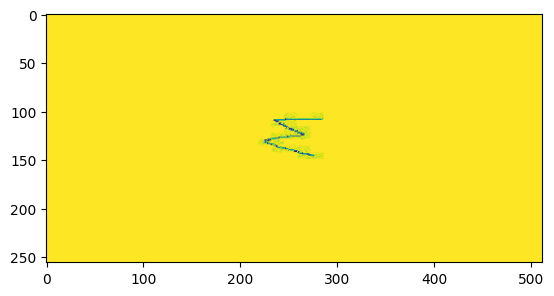

In [48]:
im, la = dataset.__getitem__(np.random.randint(0, dataset.__len__()))

plt.imshow(TT.ToPILImage()(im))
print(im.shape, la.shape)

In [49]:
len(dataset)

26141

# **🔴Data Loader**

In [50]:
train_set, valid_set = random_split(dataset, [int(len(dataset)*0.7), len(dataset)-int(len(dataset)*0.7)])
valid_set, test_set = random_split(valid_set, [int(len(valid_set)*0.6), len(valid_set)-int(len(valid_set)*0.6)])

In [51]:
len(train_set), len(valid_set), len(test_set)

(18298, 4705, 3138)

In [52]:
def collate_fn(data):
    token = Tokenizer.from_file(f"{path}/latex_tokenizer.json")
    pad_value = token.get_vocab().get('<pad>', 3)
    tensors, targets = zip(*data)
    targets = [torch.tensor(t, dtype=torch.long) for t in targets]
    features = pad_sequence(targets, padding_value=pad_value, batch_first=True)
    try:
        tensors = torch.stack(tensors)
    except RuntimeError as e:
        print(f"stack error: {e}")
        for i, t in enumerate(tensors):
            print(f"tensor shape error {i}: {t.shape}")

    return tensors, features

In [53]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=4)
valid_set = DataLoader(valid_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=True)

In [54]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([16, 1, 256, 512]), torch.Size([16, 74]))

# **🔴Metric**

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [56]:
import editdistance
from typing import Set
import torch
from torch import Tensor
from torchmetrics import Metric


class CharacterErrorRate(Metric):
    def __init__(self, ignore_indices: Set[int], *args):
        super().__init__(*args)
        self.ignore_indices = ignore_indices
        self.add_state("error", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")
        self.error: Tensor
        self.total: Tensor

    def update(self, preds, targets):
        N = preds.shape[0]
        for i in range(N):
            pred = [token for token in preds[i].tolist() if token not in self.ignore_indices]
            target = [token for token in targets[i].tolist() if token not in self.ignore_indices]
            distance = editdistance.distance(pred, target)
            if max(len(pred), len(target)) > 0:
                self.error += distance / max(len(pred), len(target))
        self.total += N

    def compute(self) -> Tensor:
        return self.error / self.total

# **🔴Functions**

In [57]:
from pathlib import Path
from typing import List

import torch
import torch.nn as nn
from pytorch_lightning import LightningModule


class LitResNetTransformer(LightningModule):
    def __init__(
        self,
        d_model: int,
        dim_feedforward: int,
        nhead: int,
        dropout: float,
        num_decoder_layers: int,
        max_output_len: int,
        lr: float = 0.001,
        weight_decay: float = 0.0001,
        milestones: List[int] = [5],
        gamma: float = 0.1,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.weight_decay = weight_decay
        self.milestones = milestones
        self.gamma = gamma

        self.tokenizer = Tokenizer.from_file(f"{path}/latex_tokenizer.json")
        self.model = ResNetTransformer(
            d_model=d_model,
            dim_feedforward=dim_feedforward,
            nhead=nhead,
            dropout=dropout,
            num_decoder_layers=num_decoder_layers,
            max_output_len=max_output_len,
            sos_index=self.tokenizer.get_vocab()['<s>'],
            eos_index=self.tokenizer.get_vocab()['</s>'],
            pad_index=self.tokenizer.get_vocab()['<pad>'],
            num_classes=self.tokenizer.get_vocab_size(),
        )
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=self.tokenizer.get_vocab()['<pad>'])
        self.val_cer = CharacterErrorRate({self.tokenizer.get_vocab()['<pad>'], self.tokenizer.get_vocab()['<s>'], self.tokenizer.get_vocab()['</s>']})
        self.test_cer = CharacterErrorRate({self.tokenizer.get_vocab()['<pad>'], self.tokenizer.get_vocab()['<s>'], self.tokenizer.get_vocab()['</s>']})

    def training_step(self, batch, batch_idx):
        imgs, targets = batch
        logits = self.model(imgs, targets[:, :-1])
        loss = self.loss_fn(logits, targets[:, 1:])
        self.log("train/loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, targets = batch
        logits = self.model(imgs, targets[:, :-1])
        loss = self.loss_fn(logits, targets[:, 1:])
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True)

        preds = self.model.predict(imgs)
        val_cer = self.val_cer(preds, targets)
        self.log("val/cer", val_cer)

    def test_step(self, batch, batch_idx):
        imgs, targets = batch
        preds = self.model.predict(imgs)
        test_cer = self.test_cer(preds, targets)
        self.log("test/cer", test_cer)

        self.test_step_outputs.append(preds)
        return preds

    def on_test_epoch_end(self):
        with open(f"{path}/test_predictions.txt", "w") as f:
            for preds in self.test_step_outputs:
                for pred in preds:
                    decoded = self.tokenizer.decode(pred.tolist())
                    decoded.append("\n")
                    decoded_str = " ".join(decoded)
                    f.write(decoded_str)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestones, gamma=self.gamma)
        return [optimizer], [scheduler]

# **🔴Model**

In [58]:
import math

import torch
import torch.nn as nn
from torch import Tensor


class PositionalEncoding2D(nn.Module):
    """2-D positional encodings for the feature maps produced by the encoder.

    Following https://arxiv.org/abs/2103.06450 by Sumeet Singh.

    Reference:
    https://github.com/full-stack-deep-learning/fsdl-text-recognizer-2021-labs/blob/main/lab9/text_recognizer/models/transformer_util.py
    """

    def __init__(self, d_model: int, max_h: int = 2000, max_w: int = 2000) -> None:
        super().__init__()
        self.d_model = d_model
        assert d_model % 2 == 0, f"Embedding depth {d_model} is not even"
        pe = self.make_pe(d_model, max_h, max_w)  # (d_model, max_h, max_w)
        self.register_buffer("pe", pe)

    @staticmethod
    def make_pe(d_model: int, max_h: int, max_w: int) -> Tensor:
        """Compute positional encoding."""
        pe_h = PositionalEncoding1D.make_pe(d_model=d_model // 2, max_len=max_h)  # (max_h, 1 d_model // 2)
        pe_h = pe_h.permute(2, 0, 1).expand(-1, -1, max_w)  # (d_model // 2, max_h, max_w)

        pe_w = PositionalEncoding1D.make_pe(d_model=d_model // 2, max_len=max_w)  # (max_w, 1, d_model // 2)
        pe_w = pe_w.permute(2, 1, 0).expand(-1, max_h, -1)  # (d_model // 2, max_h, max_w)

        pe = torch.cat([pe_h, pe_w], dim=0)  # (d_model, max_h, max_w)
        return pe

    def forward(self, x: Tensor) -> Tensor:
        """Forward pass.

        Args:
            x: (B, d_model, H, W)

        Returns:
            (B, d_model, H, W)
        """
        assert x.shape[1] == self.pe.shape[0]  # type: ignore
        x = x + self.pe[:, : x.size(2), : x.size(3)]  # type: ignore
        return x


class PositionalEncoding1D(nn.Module):
    """Classic Attention-is-all-you-need positional encoding."""

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000) -> None:
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = self.make_pe(d_model, max_len)  # (max_len, 1, d_model)
        self.register_buffer("pe", pe)

    @staticmethod
    def make_pe(d_model: int, max_len: int) -> Tensor:
        """Compute positional encoding."""
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        return pe

    def forward(self, x: Tensor) -> Tensor:
        """Forward pass.

        Args:
            x: (S, B, d_model)

        Returns:
            (B, d_model, H, W)
        """
        assert x.shape[2] == self.pe.shape[2]  # type: ignore
        x = x + self.pe[: x.size(0)]  # type: ignore
        return self.dropout(x)

In [59]:
from typing import Union

class ResNetTransformer(nn.Module):
    def __init__(
        self,
        d_model: int,
        dim_feedforward: int,
        nhead: int,
        dropout: float,
        num_decoder_layers: int,
        max_output_len: int,
        sos_index: int,
        eos_index: int,
        pad_index: int,
        num_classes: int,
    ) -> None:
        super().__init__()
        self.d_model = d_model
        self.max_output_len = max_output_len + 2
        self.sos_index = sos_index
        self.eos_index = eos_index
        self.pad_index = pad_index

        # Encoder
        resnet = torchvision.models.resnet18(pretrained=False)
        self.backbone = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
        )
        self.bottleneck = nn.Conv2d(256, self.d_model, 1)
        self.image_positional_encoder = PositionalEncoding2D(self.d_model)

        # Decoder
        self.embedding = nn.Embedding(num_classes, self.d_model)
        self.y_mask = generate_square_subsequent_mask(self.max_output_len)
        self.word_positional_encoder = PositionalEncoding1D(self.d_model, max_len=self.max_output_len)
        transformer_decoder_layer = nn.TransformerDecoderLayer(self.d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(transformer_decoder_layer, num_decoder_layers)
        self.fc = nn.Linear(self.d_model, num_classes)

        # It is empirically important to initialize weights properly
        if self.training:
            self._init_weights()

    def _init_weights(self) -> None:
        """Initialize weights."""
        init_range = 0.1
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-init_range, init_range)

        nn.init.kaiming_normal_(
            self.bottleneck.weight.data,
            a=0,
            mode="fan_out",
            nonlinearity="relu",
        )
        if self.bottleneck.bias is not None:
            _, fan_out = nn.init._calculate_fan_in_and_fan_out(self.bottleneck.weight.data)
            bound = 1 / math.sqrt(fan_out)
            nn.init.normal_(self.bottleneck.bias, -bound, bound)

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        """Forward pass.

        Args:
            x: (B, _E, _H, _W)
            y: (B, Sy) with elements in (0, num_classes - 1)

        Returns:
            (B, num_classes, Sy) logits
        """
        encoded_x = self.encode(x)  # (Sx, B, E)
        output = self.decode(y, encoded_x)  # (Sy, B, num_classes)
        output = output.permute(1, 2, 0)  # (B, num_classes, Sy)
        return output

    def encode(self, x: Tensor) -> Tensor:
        """Encode inputs.

        Args:
            x: (B, C, _H, _W)

        Returns:
            (Sx, B, E)
        """
        # Resnet expects 3 channels but training images are in gray scale
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        x = self.backbone(x)  # (B, RESNET_DIM, H, W); H = _H // 32, W = _W // 32
        x = self.bottleneck(x)  # (B, E, H, W)
        x = self.image_positional_encoder(x)  # (B, E, H, W)
        x = x.flatten(start_dim=2)  # (B, E, H * W)
        x = x.permute(2, 0, 1)  # (Sx, B, E); Sx = H * W
        return x

    def decode(self, y: Tensor, encoded_x: Tensor) -> Tensor:
        """Decode encoded inputs with teacher-forcing.

        Args:
            encoded_x: (Sx, B, E)
            y: (B, Sy) with elements in (0, num_classes - 1)

        Returns:
            (Sy, B, num_classes) logits
        """
        y = y.permute(1, 0)  # (Sy, B)
        y = self.embedding(y) * math.sqrt(self.d_model)  # (Sy, B, E)
        y = self.word_positional_encoder(y)  # (Sy, B, E)
        Sy = y.shape[0]
        y_mask = self.y_mask[:Sy, :Sy].type_as(encoded_x)  # (Sy, Sy)
        output = self.transformer_decoder(y, encoded_x, y_mask)  # (Sy, B, E)
        output = self.fc(output)  # (Sy, B, num_classes)
        return output

    def predict(self, x: Tensor) -> Tensor:
        """Make predctions at inference time.

        Args:
            x: (B, C, H, W). Input images.

        Returns:
            (B, max_output_len) with elements in (0, num_classes - 1).
        """
        B = x.shape[0]
        S = self.max_output_len

        encoded_x = self.encode(x)  # (Sx, B, E)

        output_indices = torch.full((B, S), self.pad_index).type_as(x).long()
        output_indices[:, 0] = self.sos_index
        has_ended = torch.full((B,), False)

        for Sy in range(1, S):
            y = output_indices[:, :Sy]  # (B, Sy)
            logits = self.decode(y, encoded_x)  # (Sy, B, num_classes)
            # Select the token with the highest conditional probability
            output = torch.argmax(logits, dim=-1)  # (Sy, B)
            output_indices[:, Sy] = output[-1:]  # Set the last output token

            # Early stopping of prediction loop to speed up prediction
            has_ended |= (output_indices[:, Sy] == self.eos_index).type_as(has_ended)
            if torch.all(has_ended):
                break

        # Set all tokens after end token to be padding
        eos_positions = find_first(output_indices, self.eos_index)
        for i in range(B):
            j = int(eos_positions[i].item()) + 1
            output_indices[i, j:] = self.pad_index

        return output_indices


def generate_square_subsequent_mask(size: int) -> Tensor:
    """Generate a triangular (size, size) mask."""
    mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
    return mask


def find_first(x: Tensor, element: Union[int, float], dim: int = 1) -> Tensor:
    """Find the first occurence of element in x along a given dimension.

    Args:
        x: The input tensor to be searched.
        element: The number to look for.
        dim: The dimension to reduce.

    Returns:
        Indices of the first occurence of the element in x. If not found, return the
        length of x along dim.

    Usage:
        >>> first_element(Tensor([[1, 2, 3], [2, 3, 3], [1, 1, 1]]), 3)
        tensor([2, 1, 3])

    Reference:
        https://discuss.pytorch.org/t/first-nonzero-index/24769/9

        I fixed an edge case where the element we are looking for is at index 0. The
        original algorithm will return the length of x instead of 0.
    """
    mask = x == element
    found, indices = ((mask.cumsum(dim) == 1) & mask).max(dim)
    indices[(~found) & (indices == 0)] = x.shape[dim]
    return indices

# **🔴Test**

In [ ]:
wandb.finish()

epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
train/loss,█▅▄▄▅▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▁▂▂▁▁▁▂▁▂▁▁▂▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val/cer,▆█▃▂▂▁▁▁
val/loss,██▃▂▁▁▁▁
epoch,24
train/loss,0.28092
trainer/global_step,9599
val/cer,0.29787
val/loss,0.85315


In [60]:
from argparse import Namespace
from typing import List, Optional

# import hydra
# from omegaconf import DictConfig
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback, EarlyStopping, ModelCheckpoint, LearningRateMonitor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.loggers.wandb import WandbLogger

lit_model = LitResNetTransformer(**config['lit_model']).to(device)

callbacks: List[Callback] = []
callbacks.append(ModelCheckpoint(**config['callbacks']['model_checkpoint']))
callbacks.append(EarlyStopping(**config['callbacks']['early_stopping']))

logger: Optional[WandbLogger] = None
if config['logger']:
  logger = WandbLogger(**config['logger'])

trainer = Trainer(**config['trainer'], callbacks=callbacks, logger=logger)

if trainer.logger:
    trainer.logger.log_hyperparams(Namespace(**config))

trainer.fit(lit_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
trainer.test(lit_model, dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:


Abort: 

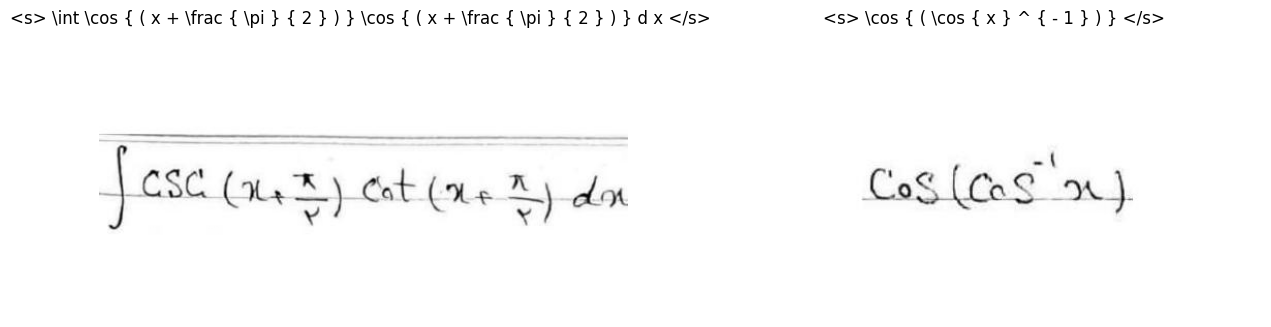

In [ ]:
import torch
import matplotlib.pyplot as plt

# 5 تصویر از test_loader دریافت کن
batch = next(iter(train_loader))
images, _ = batch  # فقط تصاویر را می‌گیریم

# 5 تصویر اول را انتخاب کن
num_images = 2
image_tensors = images[:num_images]

# نمایش و پیش‌بینی تصاویر
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    image_tensor = image_tensors[i]

    # پردیکت کردن
    pred = lit_model.model.predict(image_tensor.unsqueeze(0).float())[0]  # type: ignore
    decoded = []  # type: ignore
    for j in pred.tolist():
      if j!=3:
        decoded.append(lit_model.tokenizer.id_to_token(j))
    decoded.append("\n")
    decoded_str = " ".join(decoded)

    # نمایش تصویر
    axes[i].imshow(image_tensor.permute(1, 2, 0).cpu().numpy(), cmap="gray")  # اگر رنگی نیست cmap="gray" بگذار
    axes[i].axis("off")
    axes[i].set_title(decoded_str)

plt.show()
